import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, filters, measure
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle
import sys
import math
import matplotlib.pyplot as plt
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.network_arch_cls import *
from utils.trainval_detSegVoting import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]
1.1.0


Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [2]:
path_imdb = '/home/skong2/restore/dataset/NYUDv2-modelZipper/imdb_nyud2_complete.mat'
imdb = scipy.io.loadmat(path_imdb)
imdb = imdb['imdb']

imdb = imdb[0][0][0][0][0]  # len(.) = 10
classMapping = imdb[1][0]
colormap4class = imdb[8]

classMapping = np.asarray([0] + list(classMapping))


project_name = 'step002_det_P002_segDistTransform_v1' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)


newSize = [512, 512]
scaleList = [0]      # the number of output layer for U-net

TF2tensor = transforms.ToTensor()
TFNormalize = transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))


exp_dir = './exp' # experiment directory, used for reading the init model
save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
if not os.path.exists(save_dir): 
    os.makedirs(save_dir)

    
result_save_to_folder = './demo_show' # experiment directory, used for reading the init model
if not os.path.exists(result_save_to_folder): 
    os.makedirs(result_save_to_folder)

cuda:0


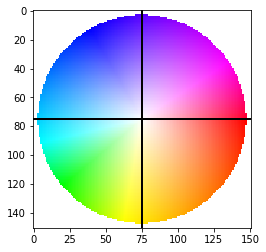

In [3]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    return mask


objDemoShowFlow = DemoShowFlow() # height=int(Y.max()), width=int(Y.max())
plt.imshow(objDemoShowFlow.FlowColorChart)
#plt.imshow(objDemoShowFlow.FlowColorChartNoAxes)
#misc.imsave(os.path.join(save_dir, 'colorchar.png'.format(idx)), objDemoShowFlow.FlowColorChart*255, format='png')

In [5]:
################## init model ###################
path_to_save_paramOnly = path.join('./exp', project_name, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=True)


curmodel.load_state_dict(torch.load(path_to_save_paramOnly, map_location='cpu'))
#curmodel.load_state_dict(torch.load(path_to_save_paramOnly), map_location='cpu')

curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

using pretrained model
False


In [6]:
className = 'mor'
imgName = '20.2005-2005-10-10.229.11.5000.15000.png'
path_to_img = '/home/skong2/project/BCI_pollenDetClsSystem/pytorch_version/demo_pics'
path_to_img = path.join(path_to_img, className, imgName)

imageOrg = PIL.Image.open(path_to_img)

image = np.array(imageOrg)
orgSize = image.shape
image = TF2tensor(image)
image = image.unsqueeze(0)
image = F.interpolate(image, size=(newSize[0], newSize[1]), mode='bilinear', align_corners=True)
image = image.squeeze(0)
image = TFNormalize(image)
image = image.unsqueeze(0)

In [7]:
image = image.to(device)
outputs = curmodel(image)
predSeg = outputs[('segMask', 0)]
predYXOffset = outputs[('output', 0)]

In [12]:
image = image.to(device)
outputs = curmodel(image)
predSeg = outputs[('segMask', 0)]
predDistTransform = outputs[('output', 0)]

idx = 0



    
##############################################
##          prediction: 
##############################################
predDistTransform_Resize = F.interpolate(predDistTransform,size=(1000,1000), mode='bilinear', align_corners=True)
predDistTransform_Resize = predDistTransform_Resize.squeeze().cpu().detach().numpy().astype(np.float32)
predDistTransform_toSave = predDistTransform_Resize / predDistTransform_Resize.max() * 255.0
    
predInstMask_toSave = predDistTransform_toSave*0
    

predBinaryMask = predSeg > 0.5
predBinaryMask = predBinaryMask.type(torch.float).squeeze().detach().cpu().numpy()
    
AAA = measure.label(predBinaryMask, background=0)
for jjj in range(1, AAA.max()):
    aaa = AAA==jjj
    if aaa.astype(np.float32).sum()<100:
        predBinaryMask[aaa] = 0
            
predBinaryMask = torch.from_numpy(predBinaryMask).unsqueeze(0).unsqueeze(0)    
predBinaryMask = predBinaryMask.type(torch.float)    

predBinaryMask_Resize = F.interpolate(predBinaryMask,size=(orgSize[0],orgSize[1]), mode='nearest')
predBinaryMask_Resize = predBinaryMask_Resize.squeeze().cpu().detach().numpy().astype(np.float32) 
predYXOffset_Resize = F.interpolate(predYXOffset,size=(orgSize[0],orgSize[1]), mode='bilinear', align_corners=True)

    
pred_distanceTransform_Resize = ndimage.distance_transform_edt(predBinaryMask_Resize)
#coord_peaks_Resize = feature.peak_local_max(-voting4center, min_distance=10)
coord_peaks_Resize = feature.peak_local_max(pred_distanceTransform_Resize, min_distance=35, exclude_border=False)
#AAA =  pred_distanceTransform_Resize-voting4center
#coord_peaks_Resize = feature.peak_local_max(AAA, min_distance=10, exclude_border=False)
    
predInstMask_toSave = predDistTransform_toSave*0    
centerMask = predDistTransform_toSave*0
detMask = predDistTransform_toSave*0
predRadiusList = []
tmpPredList = []
instIdx = 1
for i in range(coord_peaks_Resize.shape[0]):
    y, x = coord_peaks_Resize[i]
    r = pred_distanceTransform_Resize[y,x]
    predRadiusList += [r]
    tmpMask = np.zeros((predBinaryMask_Resize.shape[0], predBinaryMask_Resize.shape[1]), dtype=np.float32)
    tmpMask = create_circular_mask(tmpMask, [y, x], r, value=1)
    tmpPredList += [tmpMask.copy()]
    if r>30:
        predInstMask_toSave = create_circular_mask(predInstMask_toSave, [y, x], r, value=instIdx)
        instIdx+=1

seg40class = predInstMask_toSave.astype(np.float32)
#seg40class = classMapping[seg40class.astype(np.uint16)]
segColorShow = np.reshape(seg40class, (-1,))
segColorShow = segColorShow.astype(np.uint16)
segColorShow = colormap4class[segColorShow, :]
segColorShow = np.reshape(segColorShow, (seg40class.shape[0], seg40class.shape[1], 3))
predInstColorMask_toSave = segColorShow * 255
    
# filename = path.join(result_save_to_folder, '{:04d}_image.png'.format(iterCount))
# Image.fromarray(image_toSave.astype(np.uint8)).save(filename)
# #misc.imsave(filename, image_toSave)
# filename = path.join(result_save_to_folder, '{:04d}_predFlowVisShow.png'.format(iterCount))
# Image.fromarray(predFlowVisShow_toSave.astype(np.uint8)).save(filename)
# #misc.imsave(filename, predFlowVisShow_toSave)
# filename = path.join(result_save_to_folder, '{:04d}_grndFlowVisShow.png'.format(iterCount))
# Image.fromarray(grndFlowVisShow_toSave.astype(np.uint8)).save(filename)
# #misc.imsave(filename, grndFlowVisShow_toSave)
# filename = path.join(result_save_to_folder, '{:04d}_predInstColorMask.png'.format(iterCount))
# Image.fromarray(predInstColorMask_toSave.astype(np.uint8)).save(filename)
# #misc.imsave(filename, predInstColorMask_toSave)
# filename = path.join(result_save_to_folder, '{:04d}_grndInstColorMask.png'.format(iterCount))
# Image.fromarray(grndInstColorMask_toSave.astype(np.uint8)).save(filename)
# #misc.imsave(filename, grndInstColorMask_toSave)

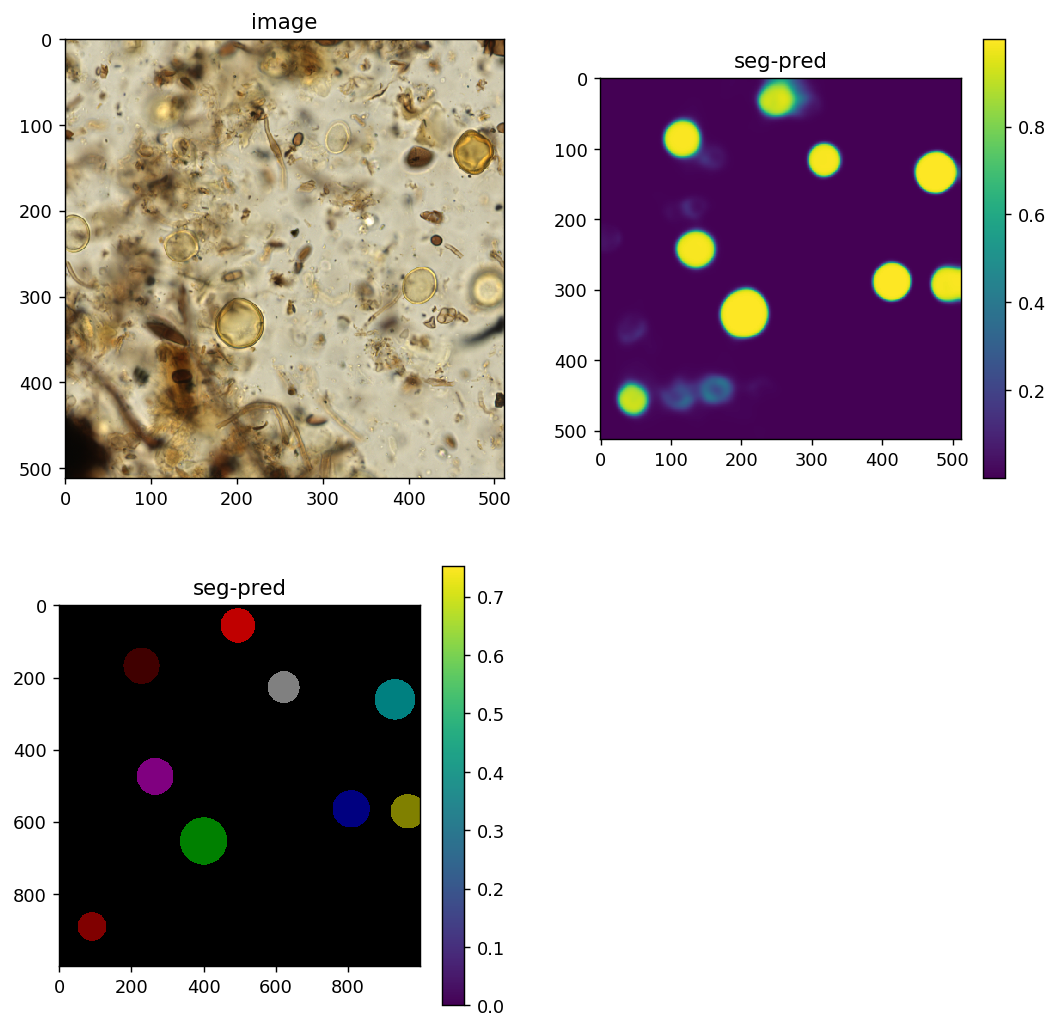

In [13]:
idx = 0

numSample2Show = 1
figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    



plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = image[idx].squeeze().cpu().detach().numpy().transpose((1,2,0))
tmpImg = (tmpImg+1)/2
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('image')



plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = predSeg[idx].squeeze().cpu().detach().numpy()
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('seg-pred')
plt.colorbar()





plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(predInstColorMask_toSave/255)#plt.axis('off')
plt.title('seg-pred')
plt.colorbar()

# classification

In [119]:
with open('dbinfo_cls_noReject_noInd.plk', 'rb') as handle:
    dbinfo = pickle.load(handle)

In [120]:
project_name = 'step009_clsGTMaskPadNoRejNoInd_P006_res34scratch_wSqrtInvFreq' 

path_to_save_paramOnly = path.join('./exp', project_name, 'j/epoch-250.paramOnly')

curmodel = PollenClsNet(34, nClass=46, pretrained=True, poolSize=16)
curmodel.load_state_dict(torch.load(path_to_save_paramOnly, map_location='cpu'))
curmodel.to(device);
curmodel.eval();
curmodel.training = False

using pretrained model


In [121]:
len(tmpPredList), len(coord_peaks_Resize), len(predRadiusList)

(31, 31, 31)

In [122]:
image = np.array(imageOrg)
orgSize = image.shape
image = TF2tensor(image)
image = TFNormalize(image)
image = image.unsqueeze(0)

predLabelList = []
predNameList = []

for i in range(len(tmpPredList)):
    tmpImg = np.zeros((1, 3, newSize[0],newSize[1]), dtype=np.float32)
    curPredSeg = tmpPredList[i]
    c_y, c_x = coord_peaks_Resize[i]
    
    top_y = int(max(c_y-predRadiusList[i],0))
    top_x = int(max(c_x-predRadiusList[i],0))
    bot_y = int(min(c_y+predRadiusList[i],1000))
    bot_x = int(min(c_x+predRadiusList[i],1000))
    curImg = image.clone()
    curImg = curImg * torch.from_numpy(tmpPredList[i]).unsqueeze(0).unsqueeze(0)
    curImg = curImg[:,:,top_y:bot_y, top_x:bot_x]
    hh, ww = curImg.shape[2:]
    cc = [int(hh/2), int(ww/2)]
    tmpImg[:,:,256-cc[0]:256-cc[0]+hh,256-cc[1]:256-cc[1]+ww] = curImg
    tmpImg = torch.from_numpy(tmpImg)
    
    tmpImg = tmpImg.to(device)
    outputs = curmodel(tmpImg)
    values, indices = outputs.detach().cpu().max(1)
    predLabelList += [indices]
    predNameList += [dbinfo['meta'][indices[0]]]
    #if i==2:
    #    break        

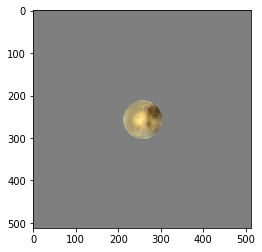

In [123]:
plt.imshow(tmpImg.squeeze().cpu().numpy().transpose((1,2,0))/2+0.5)

In [124]:
predNameList

['gus',
 'mor',
 'mor',
 'trm',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'mor',
 'alc',
 'cec',
 'als']

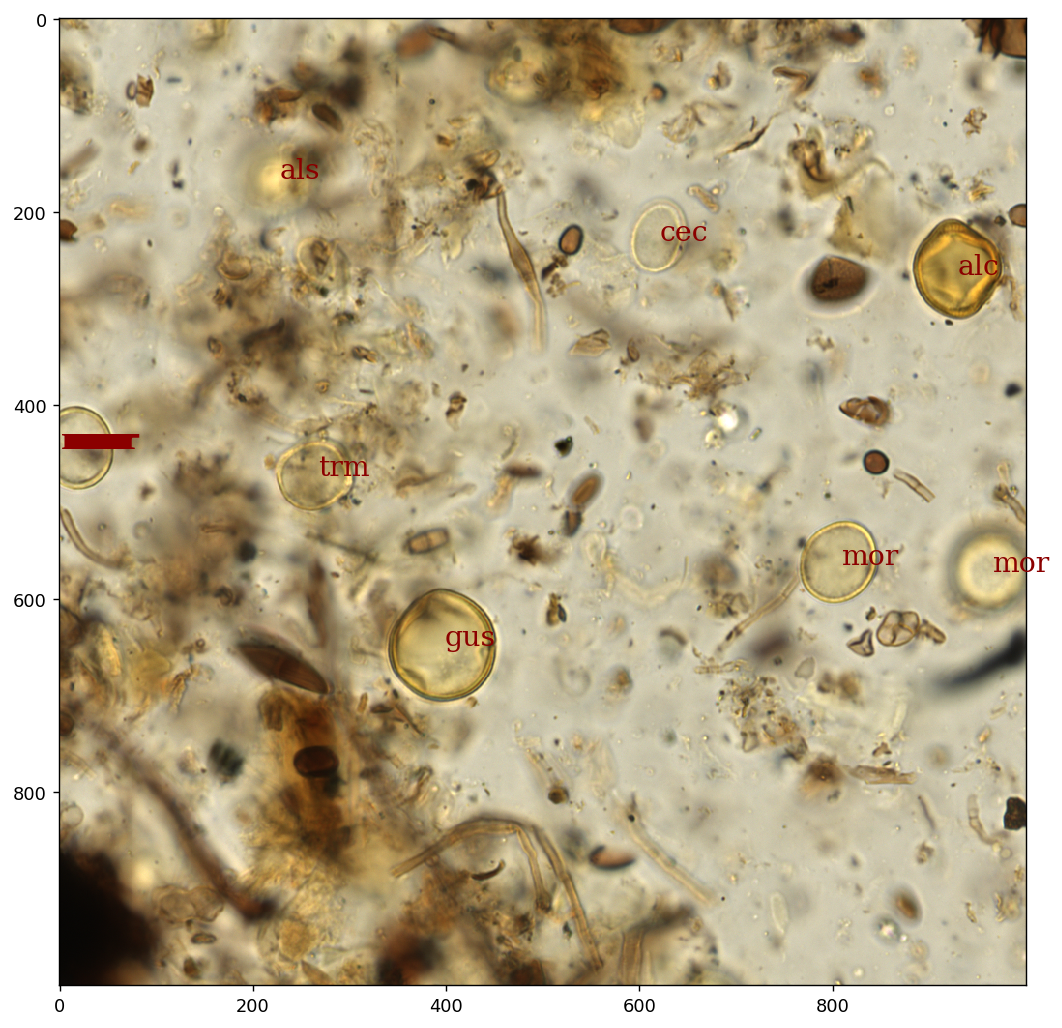

In [125]:
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }



numSample2Show = 1
figWinNumHeight, figWinNumWidth = 1, 1
plt.figure(figsize=(10, 10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    




image = np.array(imageOrg)
plt.imshow(image)

for i in range(len(tmpPredList)):
    tmpImg = np.zeros((1, 3, newSize[0],newSize[1]), dtype=np.float32)
    curPredSeg = tmpPredList[i]
    c_y, c_x = coord_peaks_Resize[i]
    plt.text(c_x, c_y, predNameList[i], fontdict=font)

plt.show()

# save visualization